In [1]:
import os
import random
import json
import pickle
import tensorflow as tf
import kagglehub as kh
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageDraw
import cv2
import random


In [2]:
tf.random.set_seed(42) # Set Random Seed

In [3]:
path = kh.dataset_download("msafi04/iss-docking-dataset") # Path for images

In [4]:
df = pd.read_csv(os.path.join(path, 'train.csv')) # Import CSV (Coordinates and distances)

In [5]:
image_paths = []
for f in os.listdir(os.path.join(path, 'train')):
    if f.startswith('.') or '.jpg' not in f:
        continue
    image_paths.append(os.path.join(path, 'train', f))
len(image_paths)
image_paths.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))
print(image_paths[:5])

['/Users/jacobbalek/.cache/kagglehub/datasets/msafi04/iss-docking-dataset/versions/1/train/0.jpg', '/Users/jacobbalek/.cache/kagglehub/datasets/msafi04/iss-docking-dataset/versions/1/train/1.jpg', '/Users/jacobbalek/.cache/kagglehub/datasets/msafi04/iss-docking-dataset/versions/1/train/2.jpg', '/Users/jacobbalek/.cache/kagglehub/datasets/msafi04/iss-docking-dataset/versions/1/train/3.jpg', '/Users/jacobbalek/.cache/kagglehub/datasets/msafi04/iss-docking-dataset/versions/1/train/4.jpg']


In [6]:
# Helper function to plot images
def plot_image(img):
    img = io.imread(img)
    fig = px.imshow(img)
    fig.show()

# Plot test images
# for i in range(3):
#     plot_image(image_paths[i])
    

In [7]:
def as_image(image_path): # Turns image into numpy array
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    return image

# as_image(image_paths[0])

In [8]:
data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)

def transform_image(img,tx=0,ty=0,zoom=1.0,rotation=0.0,shear=0.0):
    transform_parameters = {}
    orig_image = np.array(img, copy=True).reshape(512,512,3)
    transform_parameters['theta'] = rotation
    transform_parameters['zx'] = zoom
    transform_parameters['zy'] = zoom
    transform_parameters['tx'] = tx
    transform_parameters['ty'] = ty
    transform_parameters['shear'] = shear
    orig_image = image_datagen.apply_transform(x=orig_image, transform_parameters=transform_parameters)
    return orig_image

Rah

In [9]:
# Turn image into numpy array
from PIL import Image
import numpy as np

# Load the image
image = Image.open(image_paths[0])

# Convert the image to a NumPy array
numpy_array = np.asarray(image)

# Print the type and shape of the array
print(type(numpy_array))
print(numpy_array.shape)

<class 'numpy.ndarray'>
(512, 512, 3)


In [10]:
"""
# Plot using pillow
from PIL import Image

# Open the image
image = Image.open(image_paths[0])

# Rotate the image by a specified angle (in degrees)
rotated_image = image.rotate(angle=80) # Rotates by 45 degrees counter-clockwise

# Save the rotated image
rotated_image.save("rotated_image.jpg")

# Display the rotated image (optional)
rotated_image.show()
"""

'\n# Plot using pillow\nfrom PIL import Image\n\n# Open the image\nimage = Image.open(image_paths[0])\n\n# Rotate the image by a specified angle (in degrees)\nrotated_image = image.rotate(angle=80) # Rotates by 45 degrees counter-clockwise\n\n# Save the rotated image\nrotated_image.save("rotated_image.jpg")\n\n# Display the rotated image (optional)\nrotated_image.show()\n'

In [11]:
locations = df.get('location').tolist()

In [12]:
# Rotate pixel location using the rotation matrix
def rotate_pixel_location(pixel_x, pixel_y, rotation_angle):
    """
    Rotate a pixel's location around the center of the image by the given rotation angle.
    
    Args:
    - pixel_x, pixel_y: The coordinates of the pixel to rotate.
    - rotation_angle: The angle (in degrees) by which to rotate the pixel.

    Returns:
    - (new_x, new_y): The new coordinates of the rotated pixel.
    """

    center = (256, 256) # Center of image

    # Convert pixel coordinates to a 2x1 vector
    # If rotating around center of image, need center point (256,256) to be (0,0)
    pixel_coords = np.array([pixel_x, pixel_y]) # And change pixels from bottom left to rotate around the center

    # Create the rotation matrix
    M = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)
    
    # Apply the rotation matrix to the pixel coordinates
    new_coords = np.dot(M[:, :2], pixel_coords) + M[:, 2]

    new_x, new_y = new_coords
    return int(new_x), int(new_y) # Return to system where bottom left is (0,0)

In [13]:
# Read CSV
df_ISS = pd.read_csv(os.path.join(path, 'train.csv'))

M = cv2.getRotationMatrix2D((256, 256), 1, 1.0)
print(np.dot(M[:, :2], (256,256)) + M[:, 2])

[256. 256.]


In [14]:
# Rotate the images
rotated_locations = [] # Define list to store rotated pixel locations

# Rotate the images
for i in range(10000):
    
    # Open the image
    image = Image.open(image_paths[i])
    # print(image_paths[0])

    # Extract pixel
    location = df_ISS["location"][i]
    # print(location)

    # print(location)
    location = tuple(json.loads(location))

    pixel_x = location[0]
    pixel_y = location[1]

    #~~~~~~~~~~~

    # Find random angle
    random_angle = np.random.uniform(0, 360)

    # Rotate the image by a random angle specified angle (in degrees)
    rotated_image = image.rotate(angle=random_angle) # Rotates by random angle (in degrees) counter-clockwise

    # Save the rotated image
    image_path = "Rotated_ISS_imgs" # Path to save
    rotated_image.save(f"{image_path}/rotated_{i}.png")

    # Extract pixel
    location = df_ISS["location"][i]
    # print(location)
    location = tuple(json.loads(location))


    # Rotate the point

    rotated_location = list(rotate_pixel_location(pixel_x, pixel_y, random_angle))

    # print(rotated_location)
    rotated_locations.append(rotated_location)


    rotated_pixel_x = rotated_location[0]
    rotated_pixel_y = rotated_location[1]
    
    '''
    if i < 5:
        rotated_location_array = np.array(rotated_location) # for plotting

        # Draw og
        draw = ImageDraw.Draw(image)
        draw.point((pixel_x, pixel_y), fill = (255, 0, 0))
        image.show()

        # Display the rotated image with pixel
        rotated_pixel_x = rotated_location_array[0]
        rotated_pixel_y = rotated_location_array[1]
        print(rotated_location)
        # rotated_image.show()

        # Create an ImageDraw object
        rotated_draw = ImageDraw.Draw(rotated_image)
        rotated_draw.point((rotated_pixel_x, rotated_pixel_y), fill = (255, 0, 0))
        rotated_image.show()
    '''
   

In [15]:
# Make new csv with rotated locations instead
print("Original Dataframe")
print(df_ISS.head())
df_ISS_rotated = df_ISS.copy()
df_ISS_rotated['location'] = rotated_locations
print("Rotated Dataframe")
print(df_ISS_rotated.head())

# Save the csv
df_ISS_rotated.to_csv('ISS_rotated.csv', index=True)

Original Dataframe
   ImageID  distance    location
0        0       351  [215, 158]
1        1       372  [228, 269]
2        2       488  [255, 386]
3        3       308  [306, 426]
4        4        67  [248, 338]
Rotated Dataframe
   ImageID  distance    location
0        0       351  [152, 230]
1        1       372  [278, 276]
2        2       488  [262, 385]
3        3       308   [260, 78]
4        4        67  [336, 272]


In [16]:
print(df_ISS_rotated.dtypes)

ImageID      int64
distance     int64
location    object
dtype: object


[[152 230]]
<class 'numpy.ndarray'>


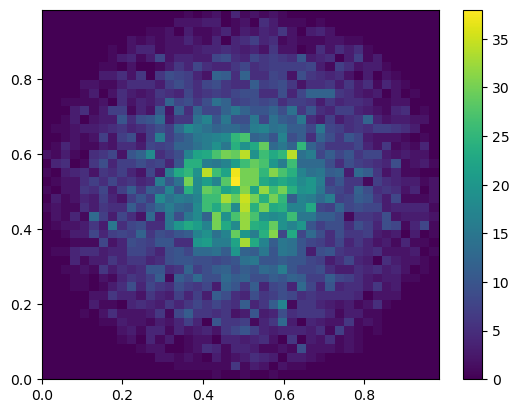

In [18]:
# Make a heatmap of the new locations

rotated_locations = df_ISS_rotated.get('location').to_list() # Extract locations from df
rotated_locations = np.array(rotated_locations)

locations = np.array(rotated_locations) # print("Rotated Heatmap")

print(locations[:1])


print(type(locations[:1]))
x, y = locations[:,0], locations[:, 1]
x, y = x/512, y/512

plt.hist2d(x,y, bins=[np.arange(0, 1,12/512),np.arange(0, 1,12/512)])
plt.colorbar()
plt.show()